<a href="https://colab.research.google.com/github/ABBuriro/WideConvNet/blob/main/WideConvNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Proposed 1D CNN**
1.   Subject wise 10-fold cross-validation performed on alcoholic EEG
dataset.
2.   
---

By: Abdul Baseer Buriro  
email: abdul.baseer@iba-suk.edu.pk  
June 05, 2024

In [ ]:
# Getting tensor flow to Build a 1D CNN with two layers (same as used in WST)
from IPython.display import clear_output
import tensorflow as tf
from tensorflow import keras
from keras import models, optimizers, utils

from keras.models import Sequential
from keras.utils import get_custom_objects

# Libraries for Model Building and EEGNet
from keras.layers import Dense, Activation, Dropout, Conv1D, Input, Flatten
from keras.layers import Average, Reshape, concatenate
from keras.layers import MaxPooling1D, BatchNormalization, AveragePooling1D
from keras.layers import Conv2D, AveragePooling2D, MaxPooling2D
from keras.layers import SeparableConv2D, DepthwiseConv2D, SpatialDropout2D
from keras.layers import SeparableConv1D, DepthwiseConv1D, SpatialDropout1D
from keras.constraints import max_norm
from keras.regularizers import l1_l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model

# Compilation
from keras.losses import categorical_crossentropy

# Call Backs (Early stopping)
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
early_stopping = EarlyStopping(monitor= 'val_accuracy',
                               patience=5,
                               min_delta=0.001,
                               mode='max'
                               )

# Performance metrics
from keras import metrics
clear_output()

# Importing required libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score,StratifiedKFold
from scipy.io import loadmat

In [ ]:
# Subjects and their corresponding labels (i.e., alcoholic/control)
Sub = np.array(['co2a0000365', 'co2a0000368',  'co2a0000369',  'co2a0000372',
                'co2a0000375', 'co2a0000377',  'co2a0000385',  'co2a0000392',
                'co2a0000398', 'co2a0000400',  'co2a0000403',  'co2a0000404',
                'co2a0000405', 'co2a0000406',  'co2a0000407',  'co2a0000409',
                'co2a0000410', 'co2a0000414',  'co2a0000415',  'co2a0000416',
                'co2c0000339', 'co2c0000340',  'co2c0000341',  'co2c0000342',
                'co2c0000344', 'co2c0000345',  'co2c0000346',  'co2c0000347',
                'co2c0000348', 'co2c0000351',  'co2c0000354',  'co2c0000356',
                'co2c0000357', 'co2c0000363',  'co2c0000374',  'co2c0000383',
                'co2c0000389', 'co2c0000393',  'co2c0000397',  'co2c1000367'])
Y = np.array(['a','a','a','a','a','a','a','a','a','a',
              'a','a','a','a','a','a','a','a','a','a',
              'c','c','c','c','c','c','c','c','c','c',
              'c','c','c','c','c','c','c','c','c','c'])

# Functions used in the main program
# ------------------------------------------------------------------------------
# 1 -Data concatenation. This function is to be used to concatenate the features
# and labels of corresponding train/test subjects
# 256 is the sampling frequency and 16 is the number of trials used
def Concatenate(subjects):
  L = len(subjects)
  EEG = np.zeros(shape=(1,16),dtype=float)
  Lab = np.zeros((1),dtype=int)
  for i in range(L):
    data = loadmat(folder+subjects[i]+'.mat')
    EEG = np.concatenate([EEG,data['ndata'][0:256*16,0:16]])
    Lab = np.concatenate([Lab,data['ndata'][0:256*16,16]])
  EEG = np.delete(EEG,0,0)
  Lab = np.delete(Lab,0,0)
  Lab = Lab.ravel()
  return (Lab, EEG)


# Preprocessing (data formatting) to use EEGNet, DeepConvet, and ShallowConvet
# NOTE: The EEG data (FULL) on UCI is a file for each trail and 120 trails for
# each subject. Total number of files = 120 trail/sub * 122 sub = 14,640 files
# OR 14,640 seconds of EEG.
# In this study, 20 alcoholic and 20 healthy subjects are included and 16 trails
# for each of 16 channels EEG as published in earlier paper in 2021.
def Preprocessing_EEGNet(X_train, Y_tain, X_test, Y_test):

  fs = 256; # sampling frequency
  trails = 16;
  ch = 16; # Number of channels
  L_tr, L_ts = int(len(Y_train)/fs), int(len(Y_test)/fs)

  Lab_tr = np.zeros(shape=(L_tr,1))
  for i in range(L_tr):
    Lab_tr[i] = int(sum(Y_train[i*fs:(i+1)*fs])/fs)

  Lab_tr = to_categorical(Lab_tr, num_classes=2)
  data_tr = X_train.reshape(L_tr,fs,ch,1)

  Lab_ts = np.zeros(shape=(L_ts,1))
  for i in range(L_ts):
    Lab_ts[i] = int(sum(Y_test[i*fs:(i+1)*fs])/fs)

  Lab_ts = to_categorical(Lab_ts, num_classes=2)
  data_ts = X_test.reshape(L_ts,fs,ch,1)
  return data_tr, Lab_tr, data_ts, Lab_ts


# Y_hat: Predictions/Estimations made by the model
# Score: Probabilities of the classes
# Labels: Actual Labels in one-hot encoded form
def Performances(Labels, Score):

  Y_hat = np.round(np.argmax(Score, axis = 1))

  # Sensitivity/Recall,
  sen = metrics.Recall();
  sen.update_state(np.argmax(Labels, axis = 1),Y_hat)
  sen = sen.result()

  # Specificity/ True Negative Rate (TN/(TN+FP))
  fp = metrics.FalsePositives()
  fp.update_state(np.argmax(Labels, axis = 1),Y_hat)

  tn = metrics.TrueNegatives()
  tn.update_state(np.argmax(Labels, axis = 1),Y_hat)

  spe = tn.result()/(tn.result()+fp.result())

  # Accuracy
  acc = metrics.BinaryAccuracy();
  acc.update_state(np.argmax(Labels, axis = 1),Y_hat)
  acc = acc.result()

  # AUC_ROC
  auc = metrics.AUC(curve="ROC",
                    summation_method="interpolation");
  auc.update_state(Labels, Score)
  auc = auc.result()

  # performances
  perf = [sen, spe, acc, auc]

  return perf

In [ ]:
# Mounting Google Drive to get data
from google.colab import drive
drive.mount('/content/drive') #force_remount=False)
folder = '/content/drive/My Drive/Alcoholic_EEG_Research_Papers/Subjectwise_data/'
# ------------------------------------------------------------------------------
clear_output()

In [ ]:
# EEGNet
'''Inputs:
Chans, Samples  : number of channels and time points in the EEG data
kernLength      : length of temporal convolution in first layer. We found
that setting this to be half the sampling rate worked well in practice.
For the SMR dataset in particular since the data was high-passed at 4 Hz we
used a kernel length of 32.
F1, F2          : number of temporal filters (F1) and number of pointwise
filters (F2) to learn. Default: F1 = 8, F2 = F1 * D.
D               : number of spatial filters to learn within each temporal
convolution. Default: D = 2
dropoutType     : Either SpatialDropout2D or Dropout, passed as a string. '''

def EEGNet(nb_classes, Chans=16, Samples=256,
           dropoutRate=0.25, kernLength=128, F1=8,
           D=2, F2=16, norm_rate=0.25, dropoutType='Dropout'):

    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D or Dropout, passed as a string.')

    # Input layer with shape (Samples, Chans, 1)
    input1 = Input(shape=(Samples, Chans, 1))

    block1 = AveragePooling2D(pool_size=(2,1),
                              strides=(2, 1))(input1) # added to get fs=128

    block1 = Conv2D(F1, (kernLength, 1), padding='same',
                    input_shape=(Samples, Chans, 1),
                    use_bias=False)(block1)
    block1 = BatchNormalization(axis=-1)(block1)
    block1 = DepthwiseConv2D((1, Chans),
                             use_bias=False,
                             depth_multiplier=D,
                             depthwise_constraint=max_norm(1.))(block1)
    block1 = BatchNormalization(axis=-1)(block1)
    block1 = Activation('elu')(block1)
    block1 = AveragePooling2D((4, 1))(block1)
    block1 = dropoutType(dropoutRate)(block1)

    block2 = SeparableConv2D(F2, (16, 1), use_bias=False, padding='same')(block1)
    block2 = BatchNormalization(axis=-1)(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((8, 1))(block2)
    block2 = dropoutType(dropoutRate)(block2)

    flatten = Flatten(name='flatten')(block2)

    dense = Dense(nb_classes,
                  name='dense',
                  kernel_initializer=keras.initializers.glorot_uniform(seed=66),
                  kernel_constraint=max_norm(norm_rate))(flatten)
    softmax = Activation('softmax', name='softmax')(dense)

    model = Model(inputs=input1, outputs=softmax)
    # Compile
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy' if nb_classes > 2 else 'binary_crossentropy',
                  metrics=['accuracy'])

    return model


def DeepConvNet(nb_classes, Chans = 16, Samples = 256,
                dropoutRate = 0.25):
    """ Keras implementation of the Deep Convolutional Network as described in
    Schirrmeister et. al. (2017), Human Brain Mapping.

    This implementation assumes the input is a 2-second EEG signal sampled at
    128Hz, as opposed to signals sampled at 250Hz as described in the original
    paper. We also perform temporal convolutions of length (1, 5) as opposed
    to (1, 10) due to this sampling rate difference.

    Note that we use the max_norm constraint on all convolutional layers, as
    well as the classification layer. We also change the defaults for the
    BatchNormalization layer. We used this based on a personal communication
    with the original authors.

                      ours        original paper
    pool_size        1, 2        1, 3
    strides          1, 2        1, 3
    conv filters     1, 5        1, 10

    Note that this implementation has not been verified by the original
    authors.

    """

    # start the model
    input_main   = Input((Samples,Chans, 1))

    block1       = Conv2D(25, (5, 1),
                          kernel_constraint = max_norm(2., axis=(0,1,2)))(input_main)
    block1       = Conv2D(25, (1, Chans),
                          kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block1       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block1)
    block1       = Activation('elu')(block1)
    block1       = MaxPooling2D(pool_size=(2, 1), strides=(2, 1))(block1)
    block1       = Dropout(dropoutRate)(block1)

    block2       = Conv2D(50, (5, 1),
                          kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block2       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block2)
    block2       = Activation('elu')(block2)
    block2       = MaxPooling2D(pool_size=(2, 1), strides=(2, 1))(block2)
    block2       = Dropout(dropoutRate)(block2)

    block3       = Conv2D(100, (5, 1),
                          kernel_constraint = max_norm(2., axis=(0,1,2)))(block2)
    block3       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block3)
    block3       = Activation('elu')(block3)
    block3       = MaxPooling2D(pool_size=(2, 1), strides=(2, 1))(block3)
    block3       = Dropout(dropoutRate)(block3)

    block4       = Conv2D(200, (5, 1),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block3)
    block4       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block4)
    block4       = Activation('elu')(block4)
    block4       = MaxPooling2D(pool_size=(2, 1), strides=(2, 1))(block4)
    block4       = Dropout(dropoutRate)(block4)

    flatten      = Flatten()(block4)

    dense        = Dense(nb_classes, kernel_constraint = max_norm(0.5))(flatten)
    softmax      = Activation('softmax')(dense)

    model = Model(inputs=input_main, outputs=softmax)

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy' if nb_classes > 2 else 'binary_crossentropy',
                  metrics=['accuracy'])

    return model


# need these for ShallowConvNet
from tensorflow.keras import backend as K
def square(x):
    return K.square(x)

def log(x):
    return K.log(K.clip(x, min_value = 1e-7, max_value = 10000))


def ShallowConvNet(nb_classes, Chans = 16, Samples = 256, dropoutRate = 0.25):
    """ Keras implementation of the Shallow Convolutional Network as described
    in Schirrmeister et. al. (2017), Human Brain Mapping.

    Assumes the input is a 2-second EEG signal sampled at 128Hz. Note that in
    the original paper, they do temporal convolutions of length 25 for EEG
    data sampled at 250Hz. We instead use length 13 since the sampling rate is
    roughly half of the 250Hz which the paper used. The pool_size and stride
    in later layers is also approximately half of what is used in the paper.

    Note that we use the max_norm constraint on all convolutional layers, as
    well as the classification layer. We also change the defaults for the
    BatchNormalization layer. We used this based on a personal communication
    with the original authors.

                     ours        original paper
    pool_size        1, 35       1, 75
    strides          1, 7        1, 15
    conv filters     1, 13       1, 25

    Note that this implementation has not been verified by the original
    authors. We do note that this implementation reproduces the results in the
    original paper with minor deviations.
    """

    # start the model
    input_main   = Input((Samples, Chans, 1))

    block1       = Conv2D(40, (13, 1),
                                 input_shape=(Chans, Samples, 1),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(input_main)
    block1       = Conv2D(40, (1, Chans), use_bias=False,
                          kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block1       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block1)
    block1       = Activation(square)(block1)
    block1       = AveragePooling2D(pool_size=(35, 1), strides=(7, 1))(block1)
    block1       = Activation(log)(block1)
    block1       = Dropout(dropoutRate)(block1)
    flatten      = Flatten()(block1)
    dense        = Dense(nb_classes, kernel_constraint = max_norm(0.5))(flatten)
    softmax      = Activation('softmax')(dense)

    model = Model(inputs=input_main, outputs=softmax)

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy' if nb_classes > 2 else 'binary_crossentropy',
                  metrics=['accuracy'])


    return model


# WideConvNet
def sqr_func(x):
  sqr = x**2
  return sqr
def abs_func(x):
  return tf.abs(x)
get_custom_objects().update({'sqr_func': Activation(sqr_func),
                             'abs_func': Activation(abs_func)})

def WideConvNet(samples=256, ch=16, nb_classes=2,
                     dropoutRate=0.5, norm_rate=0.25,
                     filt=4, pol_ds = 2, pol = 8):

  # pooling of 64 averages over quarter a second and corresponds to Scale
  # invaraince of 0.25 in WST in my previous paper
  x = Input(shape=(samples,ch))

  input_layer = AveragePooling1D(pol_ds,pol_ds)(x) # pol_ds: for downsampling
  fs = int(samples/pol_ds)

  # Since the algorithm is being used after the average pooling with pool size
  # of 2, the sampling frequency needs to be halved.

  F1 = AveragePooling1D(pol)(input_layer);

  f1 = Conv1D(filters=4, kernel_size = int(fs/2),
              padding = 'same')(input_layer);
  f2 = Conv1D(filters=4, kernel_size = int(fs/4),
              padding = 'same')(input_layer);
  f3 = Conv1D(filters=4, kernel_size = int(fs/8),
              padding = 'same')(input_layer);
  f4 = Conv1D(filters=4, kernel_size = int(fs/16),
              padding = 'same')(input_layer);
  f5 = Conv1D(filters=4, kernel_size = int(fs/32),
              padding = 'same')(input_layer);
  f6 = Conv1D(filters=4, kernel_size = int(fs/64),
              padding = 'same')(input_layer);


  p2 = concatenate([f1,f2,f3,f4,f5,f6], axis=-1)
  p2 = Activation('elu')(p2)
  F2 = AveragePooling1D(pol)(p2);

  f21 = Conv1D(filters=1, kernel_size = int(fs/2),
              padding = 'same')(p2);
  f22 = Conv1D(filters=1, kernel_size = int(fs/4),
              padding = 'same')(p2);
  f23 = Conv1D(filters=1, kernel_size = int(fs/8),
              padding = 'same')(p2);
  f24 = Conv1D(filters=1, kernel_size = int(fs/16),
              padding = 'same')(p2);
  f25 = Conv1D(filters=1, kernel_size = int(fs/32),
              padding = 'same')(p2);
  f26 = Conv1D(filters=1, kernel_size = int(fs/64),
              padding = 'same')(p2);


  p3 = concatenate([f21,f22,f23,f24,f25,f26], axis=-1)
  p3 = Activation('elu')(p3)
  F3 = AveragePooling1D(pol)(p3)

  output_layer = concatenate([F1, F2, F3], axis = -1)

  output_layer = BatchNormalization(epsilon=1e-05, momentum=0.9)(output_layer)
  output_layer = Dropout(dropoutRate)(output_layer)

  flatten = Flatten(name='flatten')(output_layer)

  dense0 = Dense(128, name = 'dense0', activation = 'elu')(flatten)
  dense1 = Dense(nb_classes, name='dense1',
                kernel_initializer=keras.initializers.glorot_uniform(seed=66),
                kernel_constraint=max_norm(norm_rate))(dense0)

  y = Activation('softmax', name='softmax')(dense1)

  model = Model(inputs=x, outputs=y)

  # Compile
  model.compile(optimizer='adam',
                loss='categorical_crossentropy' if nb_classes > 2 else 'binary_crossentropy',
                metrics=['accuracy'])
  return model

In [ ]:
# *** Main program to perform subjectwise 10-fold cross validation ***
K_test = 10;          # 10 fold inter-subject cross-validation
trails = int(16)      # 16 trails for each subject

Perf_EEGNet = np.zeros((K_test,4),dtype=float)
Perf_Wide = np.zeros((K_test,4),dtype = float)
Perf_Shallow = np.zeros((K_test,4),dtype = float)
Perf_Deep = np.zeros((K_test,4),dtype = float)

EEGNet_histories = []
Deep_histories = []
Shallow_histories = []
Wide_histories = []


cv = StratifiedKFold(n_splits=K_test,
                    shuffle=True,
                    random_state=66)
splits = cv.split(Sub,Y)

In [ ]:
i=0
for train,test in splits:
  trSub = Sub[train]
  tsSub = Sub[test]
  Y_train, X_train = Concatenate(trSub)
  Y_test, X_test = Concatenate(tsSub)
  win = int(len(Y_test)/(trails*len(tsSub)))
  scaler = StandardScaler()
  #X_train = scaler.fit_transform(X_train)
  #X_test = scaler.transform(X_test)
  trDim = X_train.shape
  X_train = X_train.reshape(trDim[0],trDim[1],1)
  tsDim = X_test.shape
  X_test = X_test.reshape(tsDim[0],tsDim[1],1)
  # Training
  data_tr, Lab_tr, data_ts, Lab_ts = Preprocessing_EEGNet(X_train,
                                                          Y_train,
                                                          X_test,
                                                          Y_test)

  EEGModel = EEGNet(nb_classes=2)
  hist_EEGNet = EEGModel.fit(data_tr,Lab_tr,
                             epochs = 100,
                             validation_split = 0.2,
                             shuffle=False,
                             callbacks = [early_stopping],
                             verbose = 0
  )
  EEGNet_histories.append(hist_EEGNet.history)

  DeepModel = DeepConvNet(nb_classes=2)
  hist_Deep = DeepModel.fit(data_tr,Lab_tr,
                            epochs = 100,
                            validation_split = 0.2,
                            shuffle=False,
                            callbacks = [early_stopping],
                            verbose = 0
  )
  Deep_histories.append(hist_Deep.history)

  ShallowModel = ShallowConvNet(nb_classes=2)
  hist_Shallow = ShallowModel.fit(data_tr,Lab_tr,
                                  epochs = 100,
                                  validation_split = 0.2,
                                  shuffle=False,
                                  callbacks = [early_stopping],
                                  verbose = 0
  )
  Shallow_histories.append(hist_Shallow.history)

  WideModel = WideConvNet(nb_classes=2)
  hist_Wide = WideModel.fit(data_tr,Lab_tr,
                            epochs = 100,
                            validation_split = 0.2,
                            shuffle=False,
                            callbacks = [early_stopping],
                            verbose = 0
  )
  Wide_histories.append(hist_Wide.history)


  # Testing
  sc_EEGModel = EEGModel.predict(data_ts);
  sc_Shallow = ShallowModel.predict(data_ts);
  sc_Deep = DeepModel.predict(data_ts);
  sc_Wide = WideModel.predict(data_ts);

  # Performances
  Perf_EEGNet[i,:]  = Performances(Lab_ts, sc_EEGModel)
  Perf_Wide[i,:] = Performances(Lab_ts, sc_Wide)
  Perf_Deep[i,:]    = Performances(Lab_ts, sc_Deep)
  Perf_Shallow[i,:] = Performances(Lab_ts, sc_Shallow)

  clear_output()
  print(Perf_EEGNet[i,:], Perf_Shallow[i,:], Perf_Deep[i,:], Perf_Wide[i,:])
  print(i)
  i = i+1


Perf_EEGNet = pd.DataFrame(Perf_EEGNet,
                           columns=['sensitivity','specificity','accuracy','AUCROC'])
Perf_Wide = pd.DataFrame(Perf_Wide,
                            columns=['sensitivity','specificity','accuracy','AUCROC'])
Perf_Shallow = pd.DataFrame(Perf_Shallow,
                            columns=['sensitivity','specificity','accuracy','AUCROC'])
Perf_Deep = pd.DataFrame(Perf_Deep,
                            columns=['sensitivity','specificity','accuracy','AUCROC'])


[0.8125     0.71875    0.765625   0.82629395] [0.71875    0.4375     0.578125   0.67504883] [0.96875    0.8125     0.890625   0.91894531] [0.84375    0.78125    0.8125     0.85327148]
9


In [ ]:
print('EEGNet','\n',
      round(Perf_EEGNet.mean(),3), 'Parameters: ', EEGModel.count_params(),'\n',
      'WideConvNet','\n',
      round(Perf_Wide.mean(),3), 'Parameters: ', WideModel.count_params(),'\n',
      'DeepConvNet', '\n',
      round(Perf_Deep.mean(),3), 'Parameters: ', DeepModel.count_params(),'\n',
      'ShallowConvNet','\n',
      round(Perf_Shallow.mean(),3), 'Parameters', ShallowModel.count_params())

EEGNet 
 sensitivity    0.662
specificity    0.488
accuracy       0.575
AUCROC         0.637
dtype: float64 Parameters:  2082 
 WideConvNet 
 sensitivity    0.719
specificity    0.672
accuracy       0.695
AUCROC         0.739
dtype: float64 Parameters:  105896 
 DeepConvNet 
 sensitivity    0.731
specificity    0.619
accuracy       0.675
AUCROC         0.721
dtype: float64 Parameters:  148077 
 ShallowConvNet 
 sensitivity    0.700
specificity    0.347
accuracy       0.523
AUCROC         0.530
dtype: float64 Parameters 28722


In [ ]:
import os
path = folder +"customAct/"

# Save the Performances
Perf_EEGNet.to_csv(path + "Perf_EEGNet.csv")
Perf_Wide.to_csv(path + "Perf_Wide.csv")
Perf_Shallow.to_csv(path + "Perf_Shallow.csv")
Perf_Deep.to_csv(path+"Perf_Deep.csv")
#if ~os.path.exists(path):
#  os.mkdir(path=path)
from tensorflow.keras.models import load_model

# Save the model
EEGModel.save(path+"Models/EEGModel.h5")
DeepModel.save(path+"Models/DeepModel.h5")
ShallowModel.save(path + "Models/ShallowModel.h5")
WideModel.save(path + "Models/WideModel.h5")
# Verify the model by printing its summary

with open(path+'Models/Wide_histories.npy', 'wb') as f:
    np.save(f, Wide_histories)
with open(path+'Models/Deep_histories.npy', 'wb') as f:
    np.save(f, Deep_histories)
with open(path+'Models/Shallow_histories.npy', 'wb') as f:
    np.save(f, Shallow_histories)
with open(path+'Models/EEGNet_histories.npy', 'wb') as f:
    np.save(f, EEGNet_histories)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
categories = ['EEGNet', 'ShallowConvNet', 'DeepConvNet', 'WideConvNet']
AUC = [Perf_EEGNet['AUCROC'],Perf_Shallow['AUCROC'],Perf_Deep['AUCROC'],Perf_Wide['AUCROC']]
ACC = [Perf_EEGNet['accuracy'],Perf_Shallow['accuracy'],Perf_Deep['accuracy'],Perf_Wide['accuracy']]
AUC = (np.array(AUC)).T
ACC = (np.array(ACC)).T

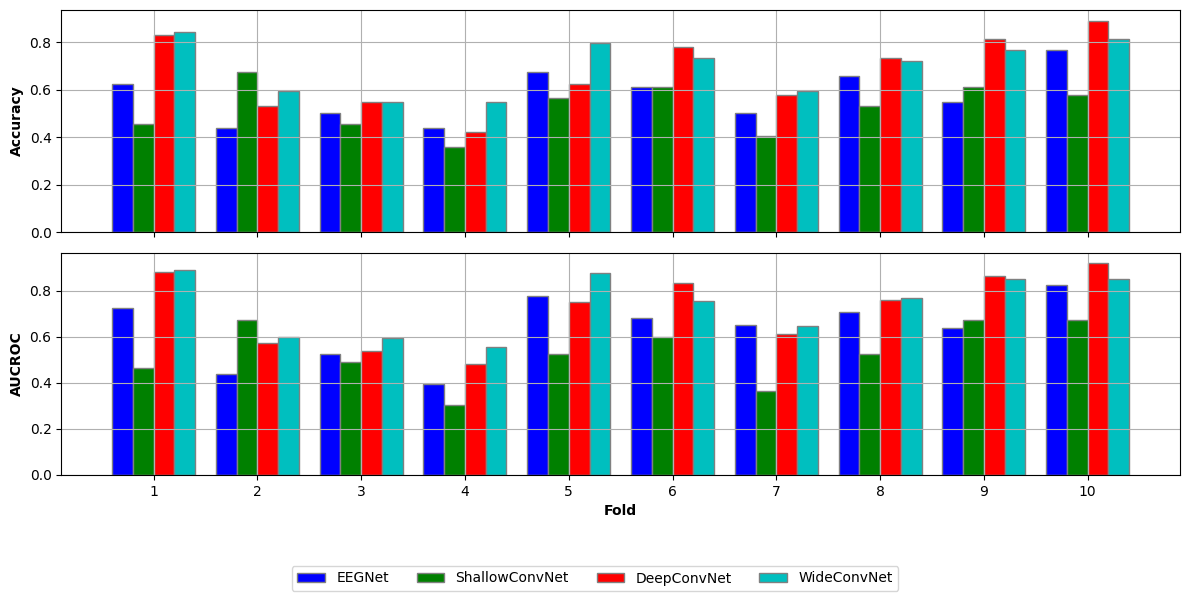

In [ ]:
folds = range(1,11)
bars = [0.0,0.2,0.4,0.6]
r1 = np.arange(len(folds))


# Create the plot
fig,ax = plt.subplots(figsize = (12,6),nrows=2,ncols=1,sharex=True)
Lab = ['EEGNet','ShallowConvNet','DeepConvNet','WideConvNet']
col = ['b','g','r','c']

# Plot each model
for i in range(4):
  r= r1+bars[i]
  ax[0].bar(r, ACC[:, i], color=col[i], width=0.2, edgecolor='grey', label=Lab[i])
  ax[1].bar(r, AUC[:, i], color=col[i], width=0.2, edgecolor='grey', label=Lab[i])


# Add labels
ax[0].set_ylabel('Accuracy', fontweight='bold')
ax[1].set_xlabel('Fold', fontweight='bold')
ax[1].set_ylabel('AUCROC', fontweight='bold')
ax[1].set_xticks([r1 + 1.5 * 0.2 for r1 in range(len(folds))], folds)

# Add legend
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center',
           bbox_to_anchor=(0.5, -0.005), ncol=4)

#fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=1)
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)

ax[0].grid(True)
ax[1].grid(True)

plt.savefig(path +'plot.png', bbox_inches = 'tight')    # Save as PNG
plt.savefig(path +'plot.pdf', bbox_inches = 'tight')    # Save as PDF
plt.savefig(path +'plot.svg', bbox_inches = 'tight')    # Save as SVG
plt.savefig(path +'plot.jpg', bbox_inches = 'tight')

# Display the plot
plt.show()